In [16]:
'-------------------------------- Load in regular libraries ------------------------------------'
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random
from sklearn.metrics import confusion_matrix

In [2]:
'-------------------------------- Load in custom libraries ------------------------------------'
from src.activation_functions import ReLU, Sigmoid, HyerbolicTangent
from src.loss_function import SoftmaxCrossEntropyLoss
from src.neural_network import Linear, NeuralNet
from src.Data import Data_Generation
from src.Training import Train_Model

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold
from itertools import product

In [4]:
'-------------------------------- Initialize custom libraries ------------------------------------'
ReL  = ReLU()
Sig  = Sigmoid()
HyT  = HyerbolicTangent()
SCE  = SoftmaxCrossEntropyLoss()
DaG  = Data_Generation() 
TrM  = Train_Model()

In [5]:
" ------------------------------ Load in custom functions ------------------------------------- " 
def construct_MLP(input_dim : int, hidden_dim : int, output_dim : int, activation : str = 'ReLU') -> np.ndarray:
    """
    Construct a multi-layer perceptron with specified architecture.
    
    Args:
        input_dim   : input feature dimension (784 for MNIST)
        hidden_dim  : list of hidden layer dimensions, e.g., [128, 64]
        output_dim  : output dimension (10 for MNIST)
        activation  : 'ReLU' or 'Sigmoid' or 'Tanh'
    
    Returns:
        Net object
    """

    activation_map = {'ReLU': ReLU, 'Sigmoid': Sigmoid, 'Tanh' : HyerbolicTangent}
    
    # Initialize:
    layers   = []
    prev_dim = input_dim

    # Construct:
    for hidden_dim_i in hidden_dim:
        
        layers.append(Linear(prev_dim, hidden_dim_i))
        layers.append(activation_map[activation]())
                        
        prev_dim = hidden_dim_i

    # Output layer (no activation - handled by loss function)
    layers.append(Linear(prev_dim, output_dim))

    return NeuralNet(layers)

def _k_fold_splitting(X : np.ndarray, y : np.ndarray, n_splits : int, shuffel : bool, 
                        seed : int = 42):
    
    kf            = KFold(n_splits = n_splits, shuffle = shuffel, random_state = seed)
    
    X_train_folds = []
    y_train_folds = []
    
    X_val_folds   = []
    y_val_folds   = []    
        
    for fold, (idx_train, idx_val) in enumerate(kf.split(X)):
        
        # Make train sets with k-fold splitting:
        X_train_folds.append(X[idx_train])
        y_train_folds.append(y[idx_train])
        
        # Make validation sets with k-fold splitting:
        X_val_folds.append(X[idx_val])
        y_val_folds.append(y[idx_val])
        
    return X_train_folds, y_train_folds, X_val_folds, y_val_folds


def get_misclassified(net, X, y):
    """
    Get indices and predictions for misclassified samples.
    """
    loss_fn     = SoftmaxCrossEntropyLoss()
    logits      = net.forward(X)
    _, probs    = loss_fn.forward(logits, y)
    predictions = np.argmax(probs, axis=1)

    misclassified_mask = predictions != y
    indices = np.where(misclassified_mask)[0]

    return indices, predictions[indices], y[indices], probs[indices]


def visualize_misclassified(X, indices, predictions, true_labels, probs, n_samples=16):
    """
    Visualize misclassified images with confidence scores.
    """
    n_samples = min(n_samples, len(indices))
    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3.5 * n_rows))
    axes = axes.flatten()

    for i in range(n_samples):
        idx = indices[i]
        img = X[idx].reshape(28, 28)
        confidence = probs[i][predictions[i]] * 100

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {true_labels[i]}, Pred: {predictions[i]}\n"
                          f"Conf: {confidence:.1f}%", fontsize=10)
        axes[i].axis('off')

    for i in range(n_samples, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Misclassified Images", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    
    # Add text annotations
    for i in range(10):
        for j in range(10):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.show()


In [6]:
activation   = 'ReLU'
n_samples    = 4
features_in  = 3
hidden_dim   = 5
features_out = 2

# Select activation function:
match activation:
    
    case 'ReLU':
        act_func = ReL
        
    case 'Sigmoid':
        act_func = Sig
        
    case 'Tanh':
        act_func = HyT
        
    case _ :
        act_func = None
        print('Please select either one of the following activation functions : "ReLU", "Sigmoid" or "Tanh".')
    
# Construct Neural Network if activation function is selected:
if act_func:   
    
    # Initialize params:
    x      = np.random.randn(n_samples, features_in)

    # Initialize neural network:
    layers = [Linear(features_in, hidden_dim), act_func, Linear(hidden_dim, features_out)]
    NN     = NeuralNet(layers)

    # Compute forward pass:
    y      = NN.forward(x)
    print(f'Forward output shape : {y.shape}')

    # Compute backward pass:
    dy     = np.ones_like(y)
    dx     = NN.backward(dy)
    print(f'Gradient shape       : {dx.shape}')
    
else:
    print('No activation function selected, therefor no neural network constructed.')

Forward output shape : (4, 2)
Gradient shape       : (4, 3)


In [7]:
# Load data generation class:
DaG  = Data_Generation()

# Load data set:
X, y = DaG._image_data(dataset = 'mnist_784', version = 1, normalize = True)

Loading "mnist_784" dataset (this might take a minute on the initial run)...
Loaded 70000 samples with 784 features


In [8]:
# Split into train, validatin and test sets:
[X_train, 
X_val, 
X_test, 
y_train, 
y_val, 
y_test] = DaG._data_splitting(X, y, mode = 'index', 
                          n_samples_train = 50000, 
                          n_samples_val   = 10000, 
                          n_samples_test  = 10000, 
                          seed = 42, shuffle = True)

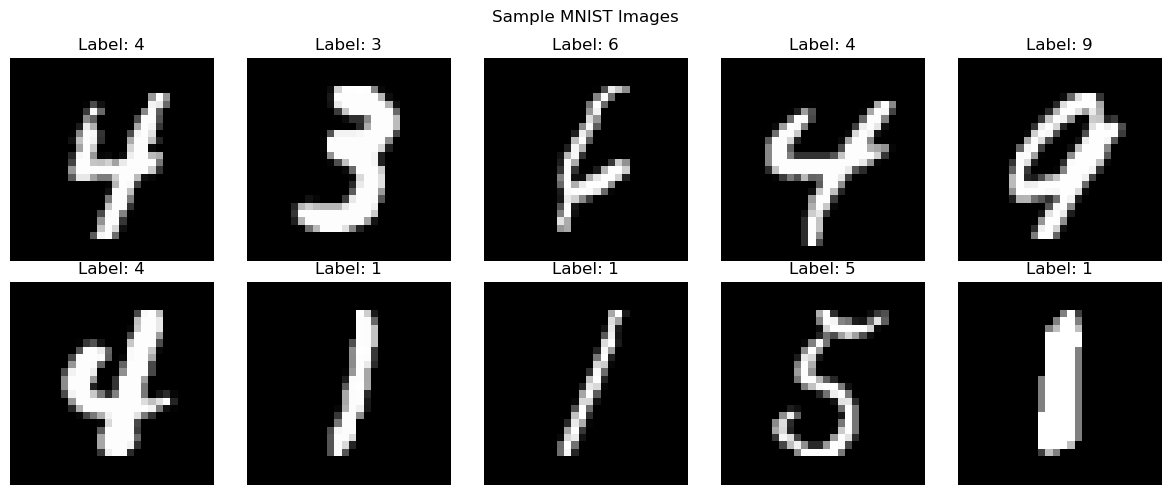

In [9]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.suptitle("Sample MNIST Images")
plt.tight_layout()
plt.show()

In [10]:
# Input params:
n_splits       = 3
shuffel        = True
seed           = 42
verbose        = True
n_samples_grid = 10000
results        = []
acc_0          = 0

# Grid parameters:
param_grid = {'hidden_dims': [[128], [256], [128, 64]],
              'activation' : ['ReLU', 'Sigmoid', 'Tanh'],  # ReLU typically works better for deep nets
              'lr'         : [0.01, 0.1],
              'batch_size' : [64, 128],
              'epochs'     : [5]}

# Make subset for grid optimization:
X_grid = X_train[:n_samples_grid]
y_grid = y_train[:n_samples_grid]

# Use k-fold splitting:
X_train_folds, y_train_folds, X_val_folds, y_val_folds = _k_fold_splitting(X_grid, y_grid, n_splits,shuffel, seed)

# Cross validation:
all_combs = list(product(*param_grid.values()))

for i, comb in enumerate(all_combs):
    params = dict(zip(param_grid.keys(), comb))
    
    if verbose:
        print(f"\n--- Config {i+1}/{len(all_combs)} ---")
        print(f"Params: hidden={params['hidden_dims']}, act={params['activation']}, "
              f"lr={params['lr']}, bs={params['batch_size']}")
    

    # Reset fold accuracy:
    fold_acc  = []
    
    for j in range(n_splits):

        # Construct MLP:
        model = construct_MLP(input_dim = X_grid.shape[1], 
                             hidden_dim = params['hidden_dims'], 
                             output_dim = len(np.unique(y_grid)), 
                             activation = params['activation'])

        # Train
        history = TrM._train(model, X_train_folds[j], y_train_folds[j],
                             X_val_folds[j], y_val_folds[j],
                             epochs     = params['epochs'], 
                             lr         = params['lr'], 
                             batch_size = params['batch_size'],
                             loss_fn    = SoftmaxCrossEntropyLoss(),
                             verbose    = False)

        fold_acc.append(max(history['val_acc']))

    
    acc_avg = np.mean(fold_acc)
    acc_std = np.std(fold_acc)
    results.append((params, acc_avg, acc_std))

    if verbose:
        print(f"Mean Acc: {acc_avg:.4f} (+/- {acc_std:.4f})")

    if acc_avg > acc_0:
        acc_0       = acc_avg
        best_params = params.copy()

print(f"\n{'='*103}")
print(f"BEST PARAMETERS: {best_params}")
print(f"{'='*103}")


--- Config 1/36 ---
Params: hidden=[128], act=ReLU, lr=0.01, bs=64
Mean Acc: 0.8355 (+/- 0.0067)

--- Config 2/36 ---
Params: hidden=[128], act=ReLU, lr=0.01, bs=128
Mean Acc: 0.7833 (+/- 0.0215)

--- Config 3/36 ---
Params: hidden=[128], act=ReLU, lr=0.1, bs=64
Mean Acc: 0.9050 (+/- 0.0075)

--- Config 4/36 ---
Params: hidden=[128], act=ReLU, lr=0.1, bs=128
Mean Acc: 0.8797 (+/- 0.0092)

--- Config 5/36 ---
Params: hidden=[128], act=Sigmoid, lr=0.01, bs=64
Mean Acc: 0.6356 (+/- 0.0083)

--- Config 6/36 ---
Params: hidden=[128], act=Sigmoid, lr=0.01, bs=128
Mean Acc: 0.5366 (+/- 0.0192)

--- Config 7/36 ---
Params: hidden=[128], act=Sigmoid, lr=0.1, bs=64
Mean Acc: 0.8606 (+/- 0.0065)

--- Config 8/36 ---
Params: hidden=[128], act=Sigmoid, lr=0.1, bs=128
Mean Acc: 0.8308 (+/- 0.0022)

--- Config 9/36 ---
Params: hidden=[128], act=Tanh, lr=0.01, bs=64
Mean Acc: 0.8378 (+/- 0.0050)

--- Config 10/36 ---
Params: hidden=[128], act=Tanh, lr=0.01, bs=128
Mean Acc: 0.7961 (+/- 0.0119)

--- C

In [11]:
# Setting up best model for full data:

# Build best model
best_model = construct_MLP(input_dim  = X.shape[1], 
                           hidden_dim = best_params['hidden_dims'], 
                           output_dim = len(np.unique(y)), 
                           activation = best_params['activation'])

# Train on full training data with more epochs
print("Training best model on full training data...")

history = TrM._train(best_model, X_train, y_train, X_val, y_val,
                     epochs = 20, lr = best_params['lr'], 
                     batch_size = best_params['batch_size'], 
                     loss_fn = SoftmaxCrossEntropyLoss(), verbose = True)

test_loss, test_acc = TrM._evaluate(best_model, X_test, y_test, SoftmaxCrossEntropyLoss(),
                                    batch_size = best_params['batch_size'] )
print(f"\n{'='*27}")
print(f"FINAL TEST ACCURACY: {test_acc:.4f}")
print(f"{'='*27}")

Training best model on full training data...
Epoch  1/20 - Train Loss : 0.4013, Train Acc: 0.8856 - Val Loss   : 0.2323, Val Acc: 0.9341
Epoch  2/20 - Train Loss : 0.1748, Train Acc: 0.9491 - Val Loss   : 0.1596, Val Acc: 0.9529
Epoch  3/20 - Train Loss : 0.1259, Train Acc: 0.9626 - Val Loss   : 0.1216, Val Acc: 0.9643
Epoch  4/20 - Train Loss : 0.0975, Train Acc: 0.9715 - Val Loss   : 0.1033, Val Acc: 0.9699
Epoch  5/20 - Train Loss : 0.0781, Train Acc: 0.9766 - Val Loss   : 0.1135, Val Acc: 0.9659
Epoch  6/20 - Train Loss : 0.0650, Train Acc: 0.9806 - Val Loss   : 0.0974, Val Acc: 0.9706
Epoch  7/20 - Train Loss : 0.0542, Train Acc: 0.9839 - Val Loss   : 0.1255, Val Acc: 0.9621
Epoch  8/20 - Train Loss : 0.0470, Train Acc: 0.9864 - Val Loss   : 0.0857, Val Acc: 0.9766
Epoch  9/20 - Train Loss : 0.0387, Train Acc: 0.9887 - Val Loss   : 0.0804, Val Acc: 0.9768
Epoch 10/20 - Train Loss : 0.0330, Train Acc: 0.9904 - Val Loss   : 0.0756, Val Acc: 0.9783
Epoch 11/20 - Train Loss : 0.0278, 

In [12]:
# Compute performance of model based on different batch sizes:
batch_sizes     = [32, 64, 128, 256]
batch_histories = {}

for bs in batch_sizes:
    print(f'Batch size: {bs}')
    model = construct_MLP(input_dim  = X.shape[1], 
                          hidden_dim = [128, 64], 
                          output_dim = len(np.unique(y)), 
                          activation = 'ReLU')
    
    # construct_MLP(784, [128, 64], 10, activation='relu')
    batch_histories[bs] = TrM._train(model, X_train, y_train, X_val, y_val,
                                     epochs = 15, lr = 0.1, batch_size = bs, 
                                     loss_fn = SoftmaxCrossEntropyLoss(), verbose=False)

# Compute performance of model based on different learning rates:

learning_rates = [0.001, 0.01, 0.1, 0.5]
lr_histories = {}

for lr in learning_rates:
    print(f'Learning rate: {lr}')
    model = construct_MLP(input_dim  = X.shape[1], 
                          hidden_dim = [128, 64], 
                          output_dim = len(np.unique(y)), 
                          activation = 'ReLU')
    
    # model = build_mlp(784, [128, 64], 10, activation='relu')
    lr_histories[lr] = TrM._train(model, X_train, y_train, X_val, y_val,
                                     epochs = 15, lr = lr, batch_size = 64, 
                                     loss_fn = SoftmaxCrossEntropyLoss(), verbose=False)

Batch size: 32
Batch size: 64
Batch size: 128
Batch size: 256
Learning rate: 0.001
Learning rate: 0.01
Learning rate: 0.1
Learning rate: 0.5


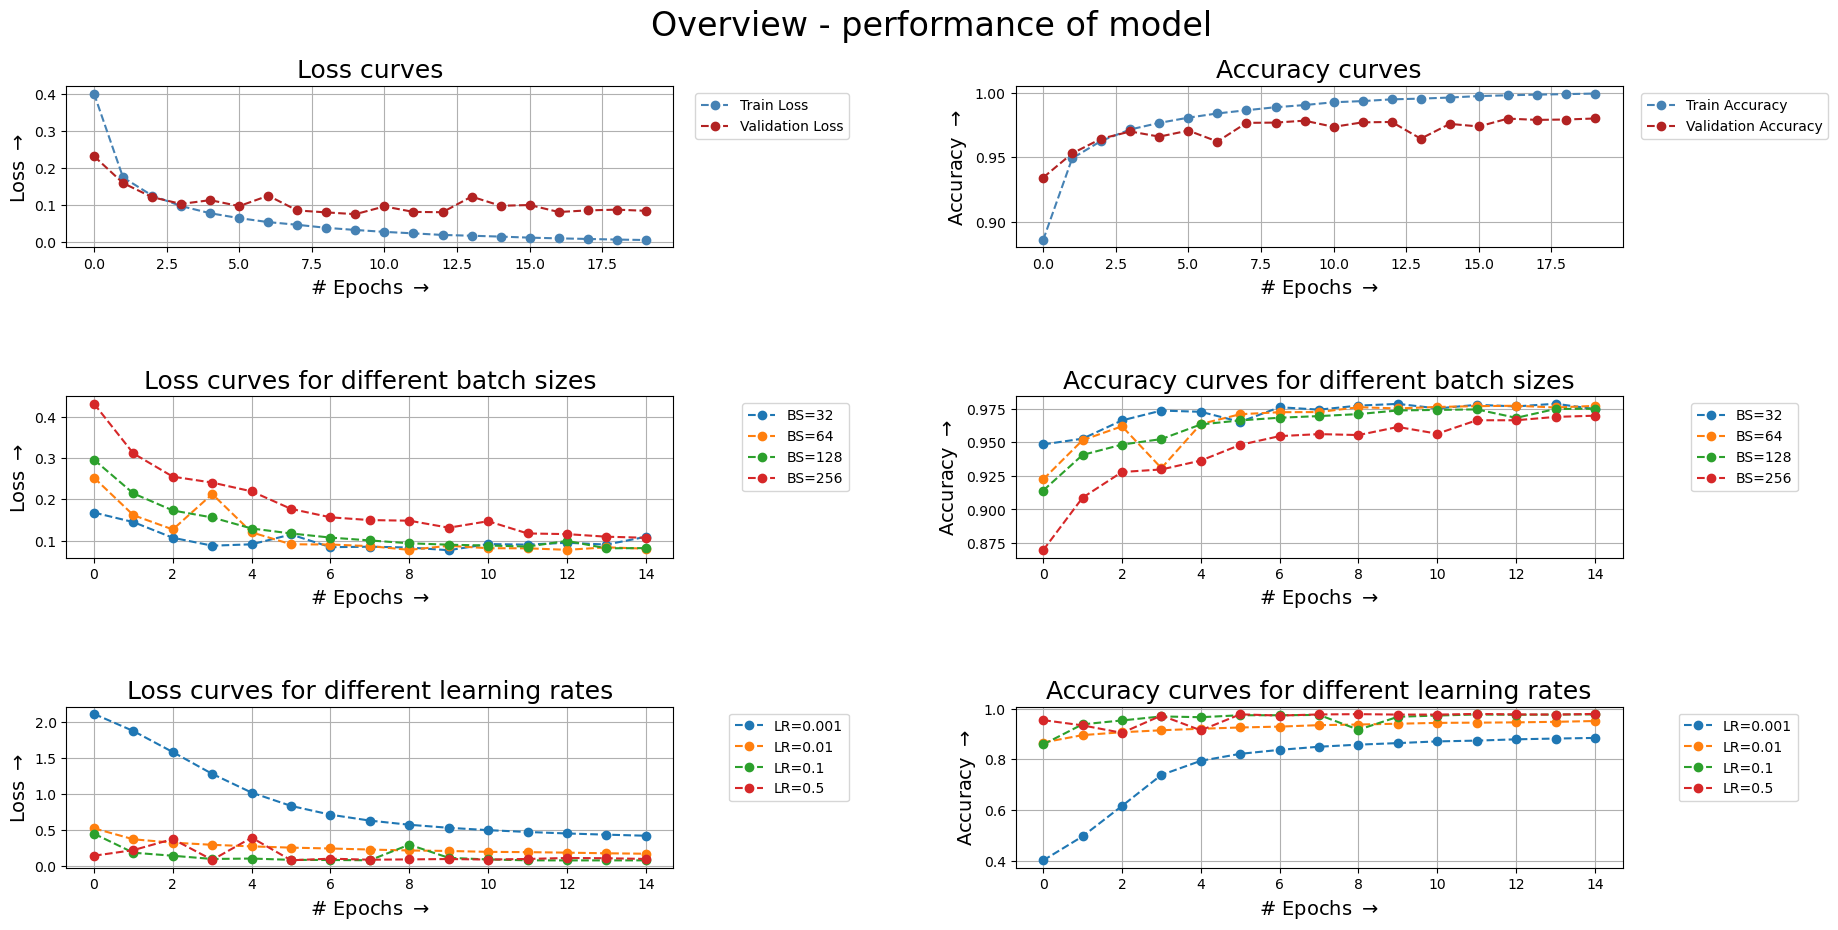

In [13]:
" ----------------------------------------- Visualizations of model performance --------------------------------------- "
save_fig = True

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 10))

" --------------------------- Best Model performance ------------------------ "

# Loss curves:
axs[0, 0].plot(history['train_loss'], label = 'Train Loss', marker = 'o', linestyle = 'dashed', color = 'steelblue')
axs[0, 0].plot(history['val_loss'], label = 'Validation Loss', marker = 'o', linestyle = 'dashed', color = 'firebrick')

axs[0, 0].grid()
axs[0, 0].legend(bbox_to_anchor=(1.3, 1.0))
axs[0, 0].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[0, 0].set_ylabel(r'Loss $\rightarrow$', fontsize = 14)
axs[0, 0].set_title('Loss curves', fontsize = 18)


# Accuracy curves:
axs[0, 1].plot(history['train_acc'], label = 'Train Accuracy', marker = 'o', linestyle = 'dashed', color = 'steelblue')
axs[0, 1].plot(history['val_acc'], label = 'Validation Accuracy', marker = 'o', linestyle = 'dashed', color = 'firebrick')

axs[0, 1].grid()
axs[0, 1].legend(bbox_to_anchor=(1.35, 1.0))
axs[0, 1].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[0, 1].set_ylabel(r'Accuracy $\rightarrow$', fontsize = 14)
axs[0, 1].set_title('Accuracy curves', fontsize = 18)


" --------------------------- Batch Size effect ------------------------ "
for bs, hist in batch_histories.items():
    axs[1, 0].plot(hist['val_loss'], label = f'BS={bs}', marker = 'o', linestyle = 'dashed')

axs[1, 0].grid()
axs[1, 0].legend(bbox_to_anchor=(1.3, 1.0))
axs[1, 0].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[1, 0].set_ylabel(r'Loss $\rightarrow$', fontsize = 14)
axs[1, 0].set_title('Loss curves for different batch sizes', fontsize = 18)

for bs, hist in batch_histories.items():
    axs[1, 1].plot(hist['val_acc'], label = f'BS={bs}', marker = 'o', linestyle = 'dashed')

axs[1, 1].grid()
axs[1, 1].legend(bbox_to_anchor=(1.3, 1.0))
axs[1, 1].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[1, 1].set_ylabel(r'Accuracy $\rightarrow$', fontsize = 14)
axs[1, 1].set_title('Accuracy curves for different batch sizes', fontsize = 18)


" --------------------------- Learning rate effect ------------------------ "
for lr, hist in lr_histories.items():
    axs[2, 0].plot(hist['val_loss'], label = f'LR={lr}', marker = 'o', linestyle = 'dashed')

axs[2, 0].grid()
axs[2, 0].legend(bbox_to_anchor=(1.3, 1.0))
axs[2, 0].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[2, 0].set_ylabel(r'Loss $\rightarrow$', fontsize = 14)
axs[2, 0].set_title('Loss curves for different learning rates', fontsize = 18)


for lr, hist in lr_histories.items():
    axs[2, 1].plot(hist['val_acc'], label = f'LR={lr}', marker = 'o', linestyle = 'dashed')

axs[2, 1].grid()
axs[2, 1].legend(bbox_to_anchor=(1.3, 1.0))
axs[2, 1].set_xlabel(r'# Epochs $\rightarrow$', fontsize = 14)
axs[2, 1].set_ylabel(r'Accuracy $\rightarrow$', fontsize = 14)
axs[2, 1].set_title('Accuracy curves for different learning rates', fontsize = 18)


fig.tight_layout(pad = 5.0)

fig.suptitle('Overview - performance of model', fontsize = 24)

if save_fig:
    fig.savefig('model_performance.png', dpi=fig.dpi)

plt.show()

Misclassified: 251 / 10000 (2.51%)


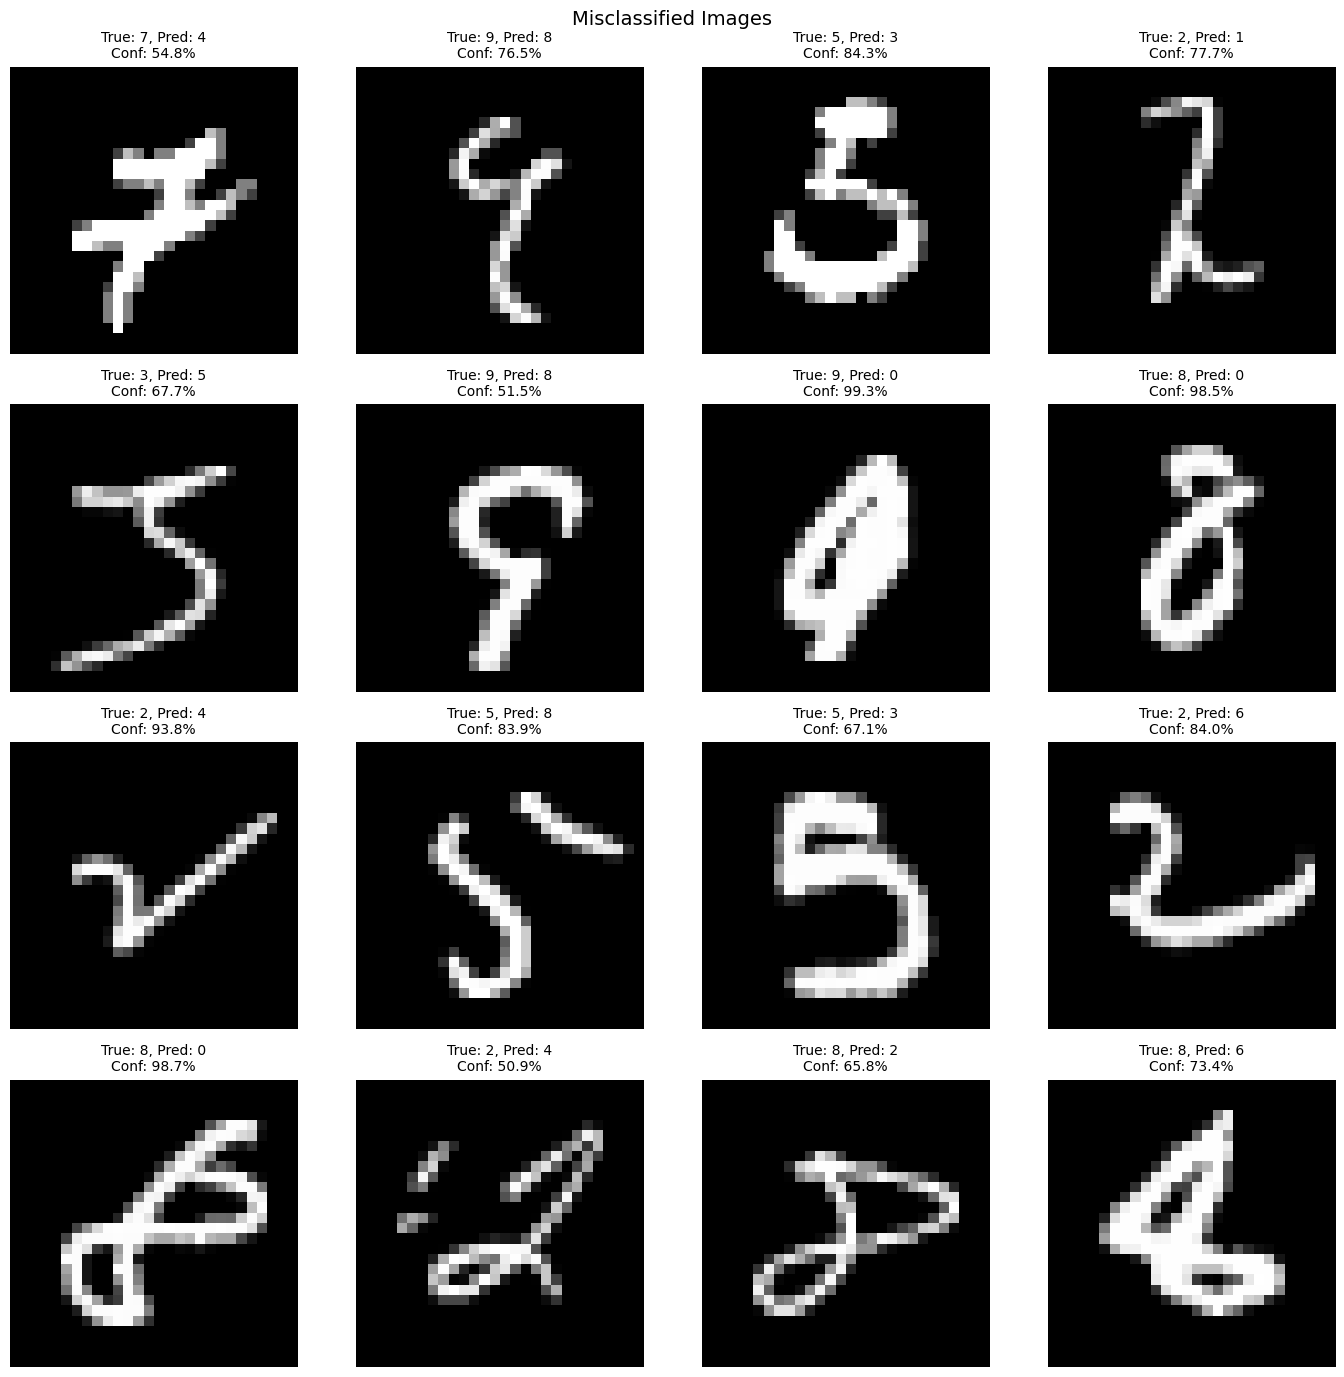

In [14]:
# Get misclassified samples
indices, preds, trues, probs = get_misclassified(best_model, X_test, y_test)
print(f"Misclassified: {len(indices)} / {len(y_test)} ({100*len(indices)/len(y_test):.2f}%)")

# Visualize
visualize_misclassified(X_test, indices, preds, trues, probs, n_samples=16)

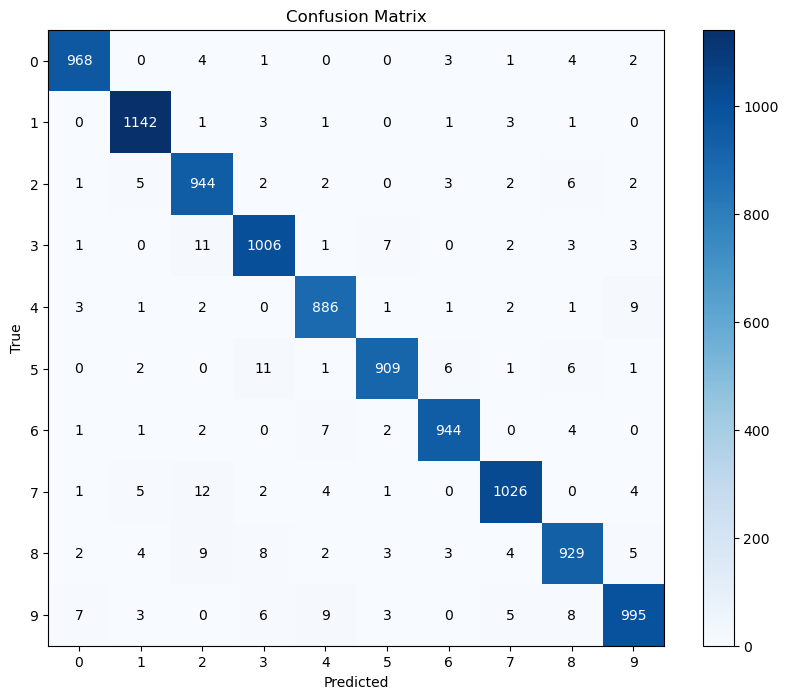

In [17]:
# Get all predictions on test set
logits       = best_model.forward(X_test)
_, all_probs = SoftmaxCrossEntropyLoss().forward(logits, y_test)
all_preds    = np.argmax(all_probs, axis=1)

plot_confusion_matrix(y_test, all_preds)